<a href="https://colab.research.google.com/github/dohuijin/KT-AIVLE-School-4th/blob/main/mini-project2/%EC%9E%A5%EC%95%A0%EC%9D%B8%EC%BD%9C%ED%83%9D%EC%8B%9C%20%EC%98%88%EC%B8%A1%20%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D/1_%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%A0%84%EC%B2%98%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 장애인콜택시 대기시간 예측
## 단계1.데이터 전처리

## 0.미션

* 1.데이터를 탐색하며 정보 획득
    * 데이터는 2015-01-01 ~ 2022-12-31 까지의 서울 장애인 콜택시 운행 정보입니다. 우리는 평균대기시간을 예측하고자 합니다.
    * 요일, 월, 계절, 연도별 운행 정보에 어떤 주기와 변화가 있는지 탐색해 봅시다.
* 2.분석을 위한 데이터 구조 만들기
    * 문제정의 :
        * 전 날 콜택시 운행이 종료되었을 때, 다음 날 대기시간을 예측하고자 합니다.

        * 만약 다음 날 대기시간을 예측할 수 있다면, 일정 범위 내에서 배차를 조절할 수 있을 뿐만 아니라, 향후 교통약자의 이동 편의 증진을 위한 정책 수립 및 개선에 기여할 수 있습니다.
    * 이를 위한 데이터 구조를 만들어 봅시다.
        * 분석 단위는 일별 데이터 입니다.
        * 주어진 데이터 : 장애인 콜택시 운행 정보, 서울시 날씨
        * 날씨 데이터는 실제 측정값이지만, 다음 날에 대한 예보 데이터로 간주합니다.
            * 예를 들어,
                * 2020-12-23 의 날씨 데이터는 전 날(12월22일) 날씨예보 데이터로 간주하여 분석을 수행합니다.
                * 2020-12-22일의 장애인 이동 데이터로 23일의 대기시간을 예측해야 하며, 이때 고려할 날씨데이터는 23일 데이터 입니다.
        * 장애인 이동 데이터를 기준으로 날씨 데이터를 붙여서 만듭시다.
        * 휴무일 데이터는 패키지를 통해서 다운받아 사용합니다.
    * Feature Engineering
        * 대기시간에 영향을 주는 요인을 도출하고(가설수립) 이를 feature로 생성합시다.
        * 주어진 그대로의 데이터가 아닌 새로운 feature를 생성해 봅시다.
            * 날짜와 관련된 feature : 요일, 월, 계절 ...
            * 시계열 특성이 반영된 feature : 최근 7일간의 평균 대기시간 ...

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

### (3) 데이터 불러오기
* 주어진 데이터셋
    * 장애인 콜택시 운행 정보 : open_data.csv
    * 날씨 데이터 : weather.csv

#### 1) 데이터로딩

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/미니프로젝트/2차_미세먼지 농도 예측, 장애인 콜택시 대기시간 예측 머신러닝 모델/2023.09.12_미니프로젝트2차_2일차 장애인 콜택시 대기시간 예측/open_data.csv')
weather=pd.read_csv('/content/drive/MyDrive/미니프로젝트/2차_미세먼지 농도 예측, 장애인 콜택시 대기시간 예측 머신러닝 모델/2023.09.12_미니프로젝트2차_2일차 장애인 콜택시 대기시간 예측/weather.csv')

In [ ]:
print(data)
print(weather)

             기준일  차량운행   접수건   탑승건  평균대기시간  평균요금  평균승차거리
0     2015-01-01   213  1023   924    23.2  2427   10764
1     2015-01-02   420  3158  2839    17.2  2216    8611
2     2015-01-03   209  1648  1514    26.2  2377   10198
3     2015-01-04   196  1646  1526    24.5  2431   10955
4     2015-01-05   421  4250  3730    26.2  2214    8663
...          ...   ...   ...   ...     ...   ...     ...
2917  2022-12-27   669  5635  4654    44.4  2198    8178
2918  2022-12-28   607  5654  4648    44.8  2161    7882
2919  2022-12-29   581  5250  4247    52.5  2229    8433
2920  2022-12-30   600  5293  4200    38.3  2183    8155
2921  2022-12-31   263  2167  1806    33.7  2318    9435

[2922 rows x 7 columns]
            Date  temp_max  temp_min  rain(mm)  humidity_max(%)  \
0     2012-01-01       0.4      -6.6       0.0             77.0   
1     2012-01-02      -1.2      -8.3       0.0             80.0   
2     2012-01-03      -0.4      -6.6       0.4             86.0   
3     2012-01-04      -

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   기준일     2922 non-null   object 
 1   차량운행    2922 non-null   int64  
 2   접수건     2922 non-null   int64  
 3   탑승건     2922 non-null   int64  
 4   평균대기시간  2922 non-null   float64
 5   평균요금    2922 non-null   int64  
 6   평균승차거리  2922 non-null   int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 159.9+ KB


In [ ]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             4018 non-null   object 
 1   temp_max         4018 non-null   float64
 2   temp_min         4018 non-null   float64
 3   rain(mm)         4018 non-null   float64
 4   humidity_max(%)  4018 non-null   float64
 5   humidity_min(%)  4018 non-null   float64
 6   sunshine(MJ/m2)  4018 non-null   float64
dtypes: float64(6), object(1)
memory usage: 219.9+ KB


In [ ]:
# '기준일' 컬럼 타입 변경
data['기준일'] = pd.to_datetime(data['기준일'])
weather['Date'] = pd.to_datetime(weather['Date'])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   기준일     2922 non-null   datetime64[ns]
 1   차량운행    2922 non-null   int64         
 2   접수건     2922 non-null   int64         
 3   탑승건     2922 non-null   int64         
 4   평균대기시간  2922 non-null   float64       
 5   평균요금    2922 non-null   int64         
 6   평균승차거리  2922 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 159.9 KB


In [ ]:
print(data.shape)
print(weather.shape)

(2922, 7)
(4018, 7)


#### 2) 칼럼이름을 영어로 변경

In [ ]:
data.columns = ['Date', 'car_cnt', 'request_cnt', 'ride_cnt', 'waiting_time', 'fare', 'distance']
data.head()

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance
0,2015-01-01,213,1023,924,23.2,2427,10764
1,2015-01-02,420,3158,2839,17.2,2216,8611
2,2015-01-03,209,1648,1514,26.2,2377,10198
3,2015-01-04,196,1646,1526,24.5,2431,10955
4,2015-01-05,421,4250,3730,26.2,2214,8663


### (2) 주기별 분석을 위해서 날짜 변수 추가하기
* data를 복사합니다.
* 복사한 df에 요일, 주차, 월, 연도 등을 추가합니다.

In [ ]:
df1 = data.copy()
df2 = weather.copy()

In [ ]:
df1['weekday'] = df1['Date'].dt.weekday
df1['week'] = df1['Date'].dt.week
df1['month'] = df1['Date'].dt.month
df1['year'] = df1['Date'].dt.year

df2['weekday'] = df2['Date'].dt.weekday
df2['week'] = df2['Date'].dt.week
df2['month'] = df2['Date'].dt.month
df2['year'] = df2['Date'].dt.year

<ipython-input-169-8c1fcba5fd00>:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df1['week'] = df1['Date'].dt.week
<ipython-input-169-8c1fcba5fd00>:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week'] = df2['Date'].dt.week


In [ ]:
print(df1)
print(df2)

           Date  car_cnt  request_cnt  ride_cnt  waiting_time  fare  distance  \
0    2015-01-01      213         1023       924          23.2  2427     10764   
1    2015-01-02      420         3158      2839          17.2  2216      8611   
2    2015-01-03      209         1648      1514          26.2  2377     10198   
3    2015-01-04      196         1646      1526          24.5  2431     10955   
4    2015-01-05      421         4250      3730          26.2  2214      8663   
...         ...      ...          ...       ...           ...   ...       ...   
2917 2022-12-27      669         5635      4654          44.4  2198      8178   
2918 2022-12-28      607         5654      4648          44.8  2161      7882   
2919 2022-12-29      581         5250      4247          52.5  2229      8433   
2920 2022-12-30      600         5293      4200          38.3  2183      8155   
2921 2022-12-31      263         2167      1806          33.7  2318      9435   

      weekday  week  month 

### (3) 일별 (lineplot 활용)
* 차량 운행수

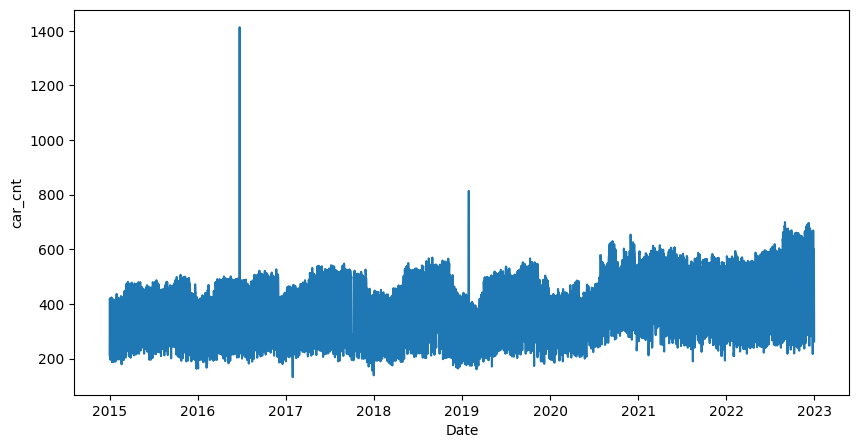

In [ ]:
plt.figure(figsize = (10, 5))
sns.lineplot(x='Date', y='car_cnt', data=df1)
plt.show()

* 접수건

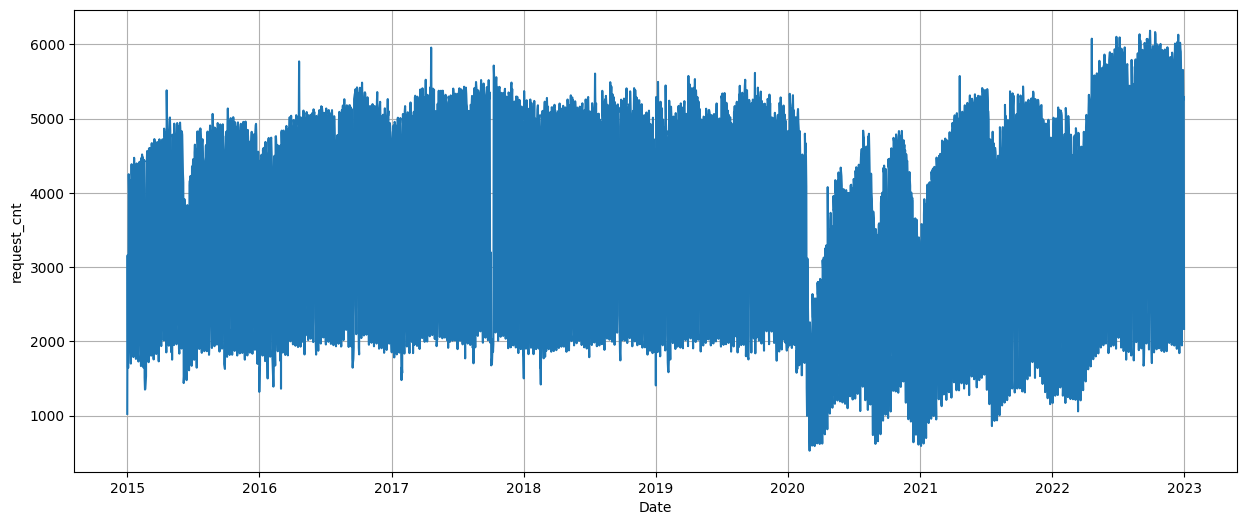

In [ ]:
plt.figure(figsize=(15, 6))
sns.lineplot(x='Date', y='request_cnt', data=df1)
plt.xlabel('Date')
plt.ylabel('request_cnt')
plt.grid()
plt.show()

* 탑승건

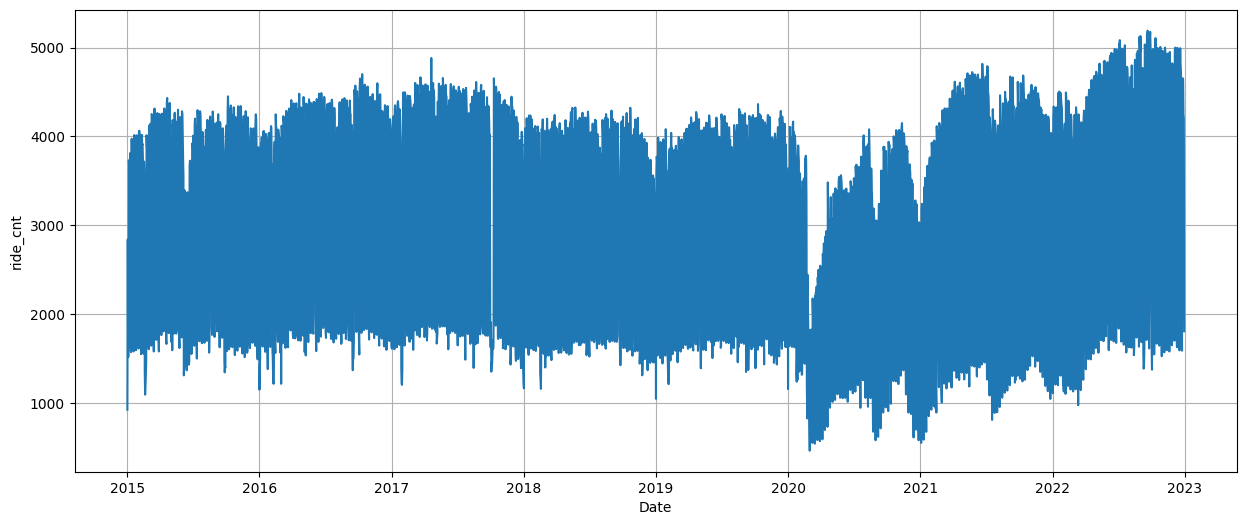

In [ ]:
plt.figure(figsize=(15, 6))
sns.lineplot(x='Date', y='ride_cnt', data=df1)
plt.xlabel('Date')
plt.ylabel('ride_cnt')
plt.grid()
plt.show()

* 대기시간

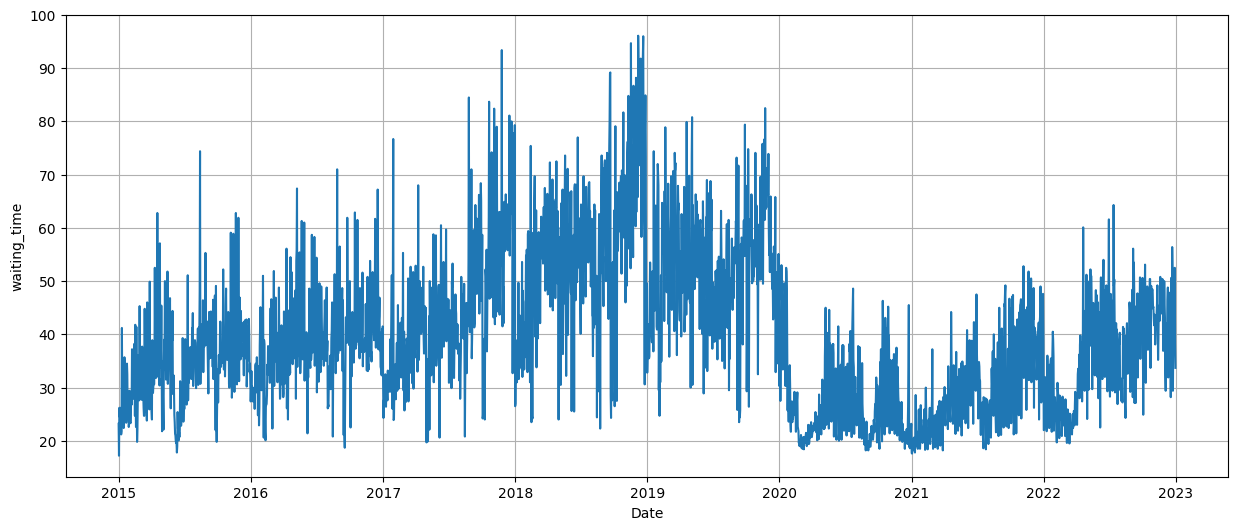

In [ ]:
plt.figure(figsize=(15, 6))
sns.lineplot(x='Date', y='waiting_time', data=df1)
plt.xlabel('Date')
plt.ylabel('waiting_time')
plt.grid()
plt.show()

* 운임

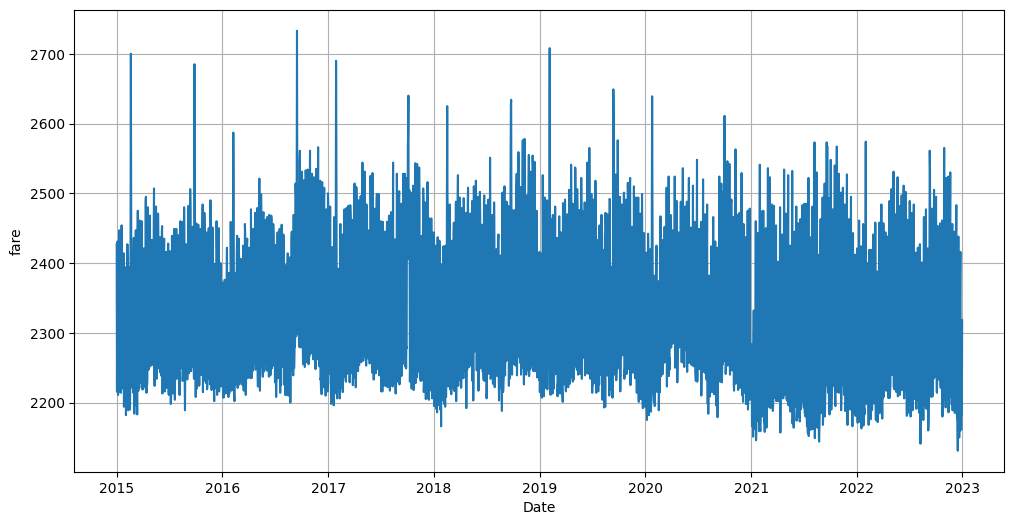

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df1['Date'], df1['fare'])
plt.xlabel('Date')
plt.ylabel('fare')
plt.grid()
plt.show()

* 이동거리

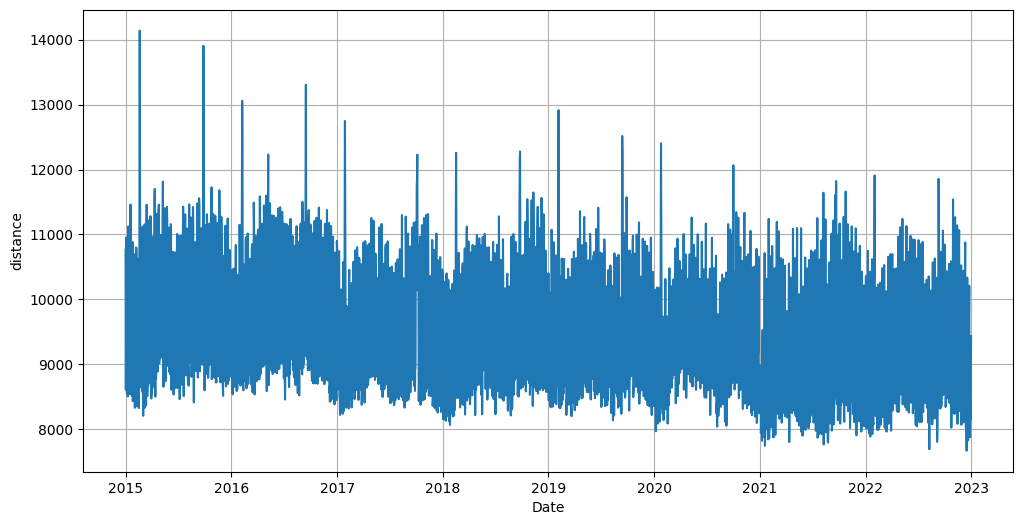

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df1['Date'], df1['distance'])
plt.xlabel('Date')
plt.ylabel('distance')
plt.grid()
plt.show()

### (4) 요일별 (boxplot활용)

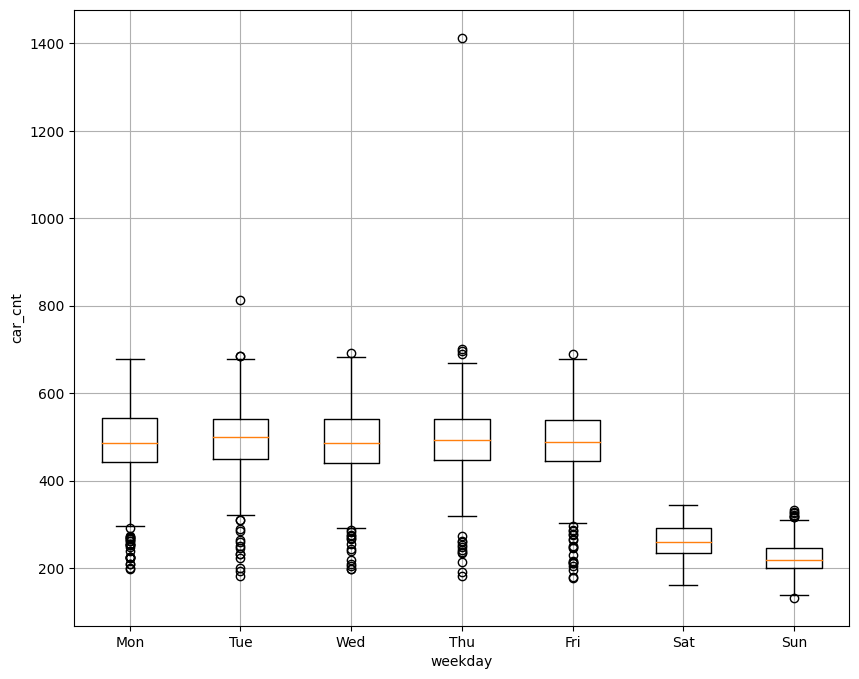

In [ ]:
plt.figure(figsize=(10, 8))
plt.boxplot([df1[df1['weekday'] == 0]['car_cnt'],
             df1[df1['weekday'] == 1]['car_cnt'],
             df1[df1['weekday'] == 2]['car_cnt'],
             df1[df1['weekday'] == 3]['car_cnt'],
             df1[df1['weekday'] == 4]['car_cnt'],
             df1[df1['weekday'] == 5]['car_cnt'],
             df1[df1['weekday'] == 6]['car_cnt']],
            labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('weekday')
plt.ylabel('car_cnt')
plt.grid()
plt.show()

* 접수건

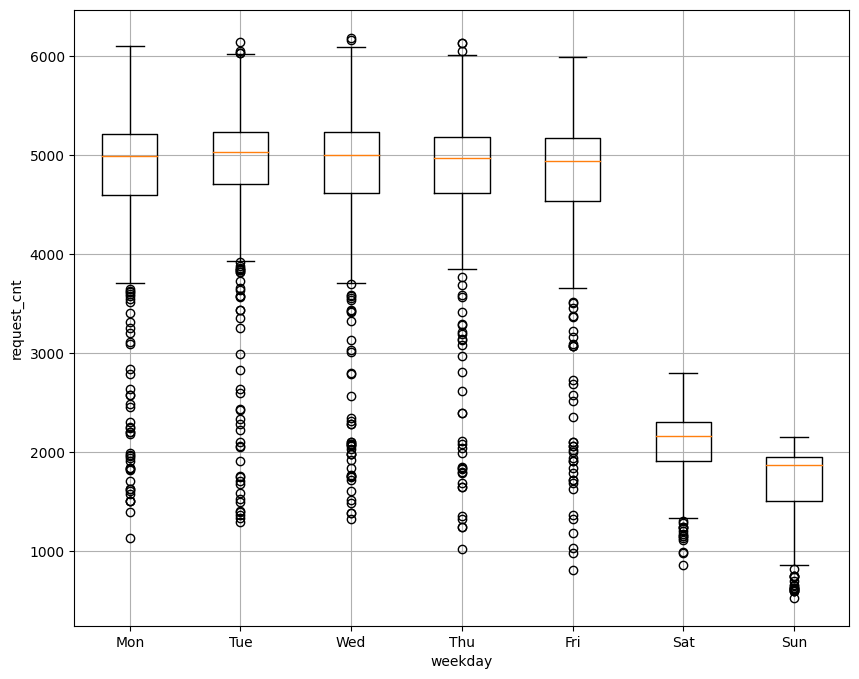

In [ ]:
plt.figure(figsize=(10, 8))
plt.boxplot([df1[df1['weekday'] == 0]['request_cnt'],
             df1[df1['weekday'] == 1]['request_cnt'],
             df1[df1['weekday'] == 2]['request_cnt'],
             df1[df1['weekday'] == 3]['request_cnt'],
             df1[df1['weekday'] == 4]['request_cnt'],
             df1[df1['weekday'] == 5]['request_cnt'],
             df1[df1['weekday'] == 6]['request_cnt']],
            labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('weekday')
plt.ylabel('request_cnt')
plt.grid()
plt.show()

* 탑승건

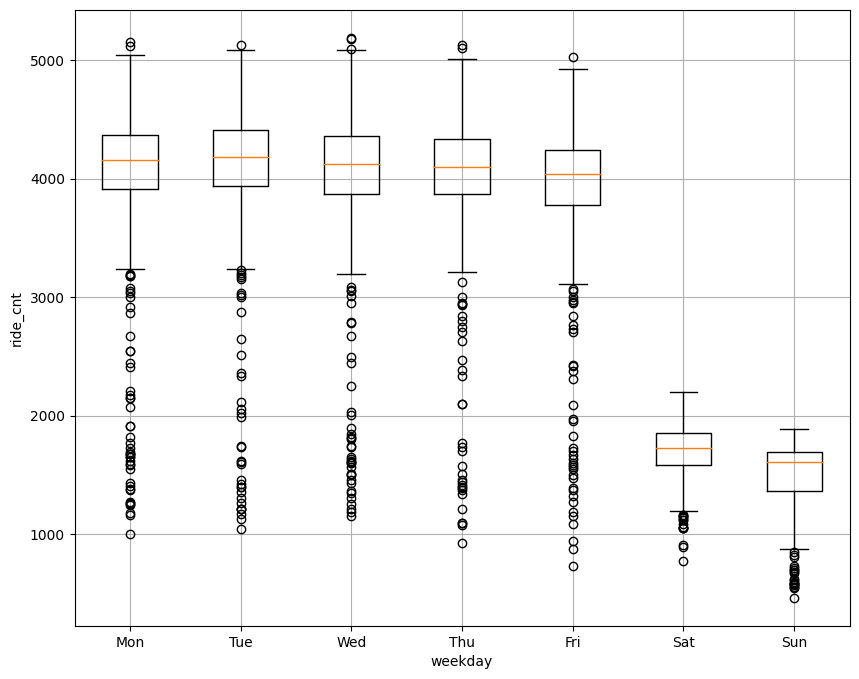

In [ ]:
plt.figure(figsize=(10, 8))
plt.boxplot([df1[df1['weekday'] == 0]['ride_cnt'],
             df1[df1['weekday'] == 1]['ride_cnt'],
             df1[df1['weekday'] == 2]['ride_cnt'],
             df1[df1['weekday'] == 3]['ride_cnt'],
             df1[df1['weekday'] == 4]['ride_cnt'],
             df1[df1['weekday'] == 5]['ride_cnt'],
             df1[df1['weekday'] == 6]['ride_cnt']],
            labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('weekday')
plt.ylabel('ride_cnt')
plt.grid()
plt.show()

* 대기시간

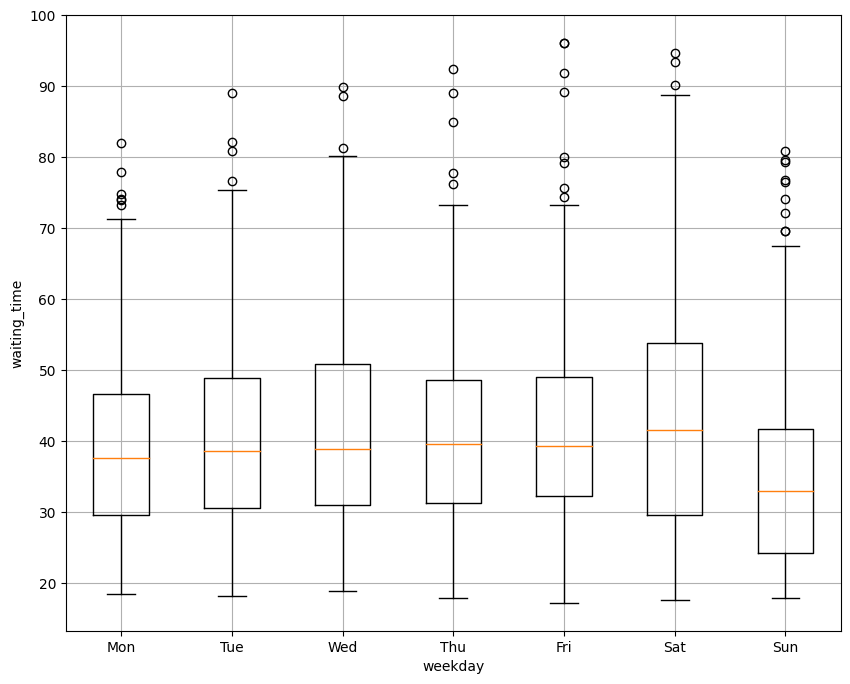

In [ ]:
plt.figure(figsize=(10, 8))
plt.boxplot([df1[df1['weekday'] == 0]['waiting_time'],
             df1[df1['weekday'] == 1]['waiting_time'],
             df1[df1['weekday'] == 2]['waiting_time'],
             df1[df1['weekday'] == 3]['waiting_time'],
             df1[df1['weekday'] == 4]['waiting_time'],
             df1[df1['weekday'] == 5]['waiting_time'],
             df1[df1['weekday'] == 6]['waiting_time']],
            labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('weekday')
plt.ylabel('waiting_time')
plt.grid()
plt.show()

* 운임

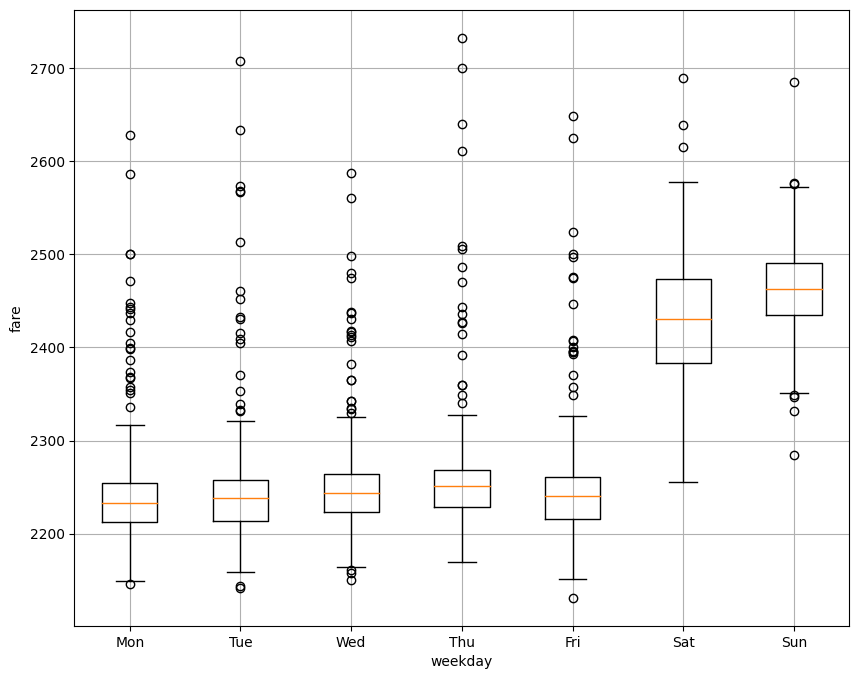

In [ ]:
plt.figure(figsize=(10, 8))
plt.boxplot([df1[df1['weekday'] == 0]['fare'],
             df1[df1['weekday'] == 1]['fare'],
             df1[df1['weekday'] == 2]['fare'],
             df1[df1['weekday'] == 3]['fare'],
             df1[df1['weekday'] == 4]['fare'],
             df1[df1['weekday'] == 5]['fare'],
             df1[df1['weekday'] == 6]['fare']],
            labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('weekday')
plt.ylabel('fare')
plt.grid()
plt.show()

* 이동거리

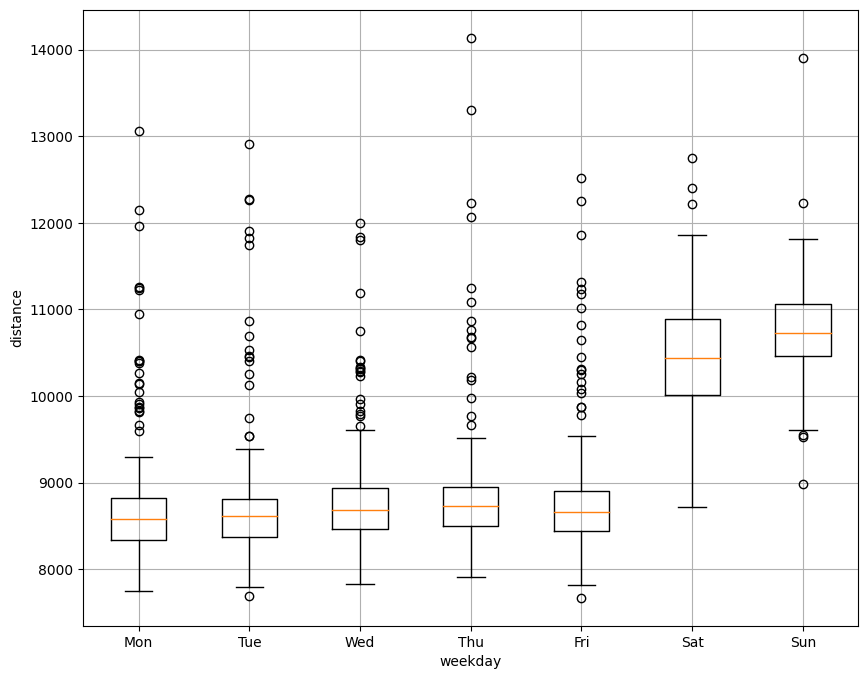

In [ ]:
plt.figure(figsize=(10, 8))
plt.boxplot([df1[df1['weekday'] == 0]['distance'],
             df1[df1['weekday'] == 1]['distance'],
             df1[df1['weekday'] == 2]['distance'],
             df1[df1['weekday'] == 3]['distance'],
             df1[df1['weekday'] == 4]['distance'],
             df1[df1['weekday'] == 5]['distance'],
             df1[df1['weekday'] == 6]['distance']],
            labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('weekday')
plt.ylabel('distance')
plt.grid()
plt.show()

In [ ]:
### (5) 월별 (boxplot활용)

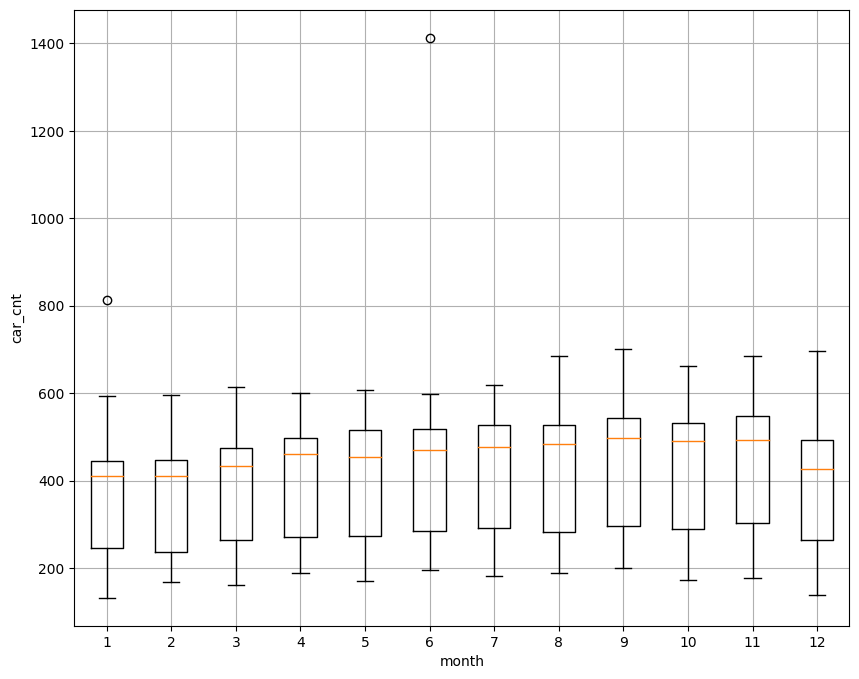

In [ ]:
plt.figure(figsize=(10, 8))
plt.boxplot([df1[df1['month'] == 1]['car_cnt'],
             df1[df1['month'] == 2]['car_cnt'],
             df1[df1['month'] == 3]['car_cnt'],
             df1[df1['month'] == 4]['car_cnt'],
             df1[df1['month'] == 5]['car_cnt'],
             df1[df1['month'] == 6]['car_cnt'],
             df1[df1['month'] == 7]['car_cnt'],
             df1[df1['month'] == 8]['car_cnt'],
             df1[df1['month'] == 9]['car_cnt'],
             df1[df1['month'] == 10]['car_cnt'],
             df1[df1['month'] == 11]['car_cnt'],
             df1[df1['month'] == 12]['car_cnt']],
            labels=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
plt.xlabel('month')
plt.ylabel('car_cnt')
plt.grid()
plt.show()

* 접수건

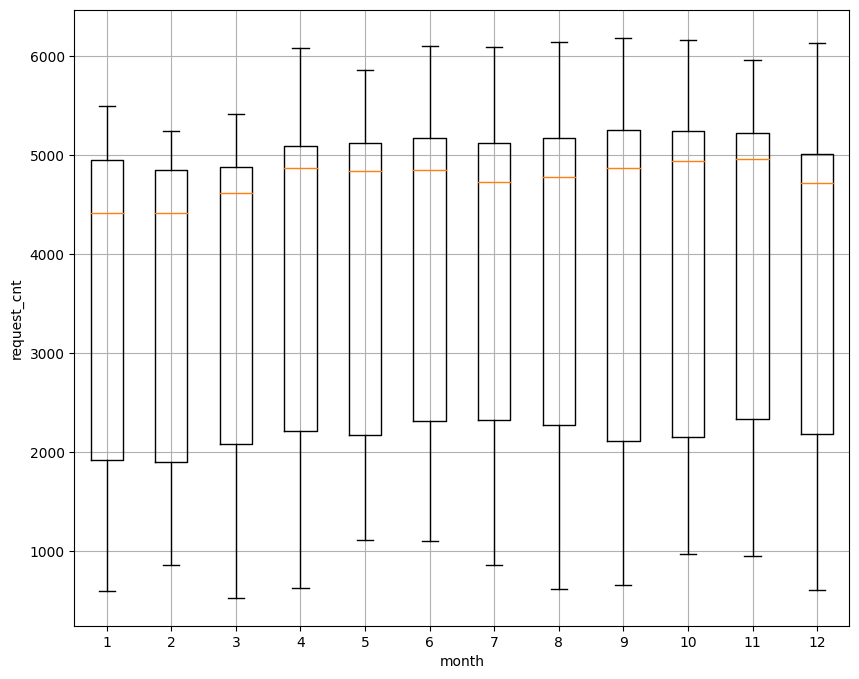

In [ ]:
plt.figure(figsize=(10, 8))
plt.boxplot([df1[df1['month'] == 1]['request_cnt'],
             df1[df1['month'] == 2]['request_cnt'],
             df1[df1['month'] == 3]['request_cnt'],
             df1[df1['month'] == 4]['request_cnt'],
             df1[df1['month'] == 5]['request_cnt'],
             df1[df1['month'] == 6]['request_cnt'],
             df1[df1['month'] == 7]['request_cnt'],
             df1[df1['month'] == 8]['request_cnt'],
             df1[df1['month'] == 9]['request_cnt'],
             df1[df1['month'] == 10]['request_cnt'],
             df1[df1['month'] == 11]['request_cnt'],
             df1[df1['month'] == 12]['request_cnt']],
            labels=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
plt.xlabel('month')
plt.ylabel('request_cnt')
plt.grid()
plt.show()

* 탑승건

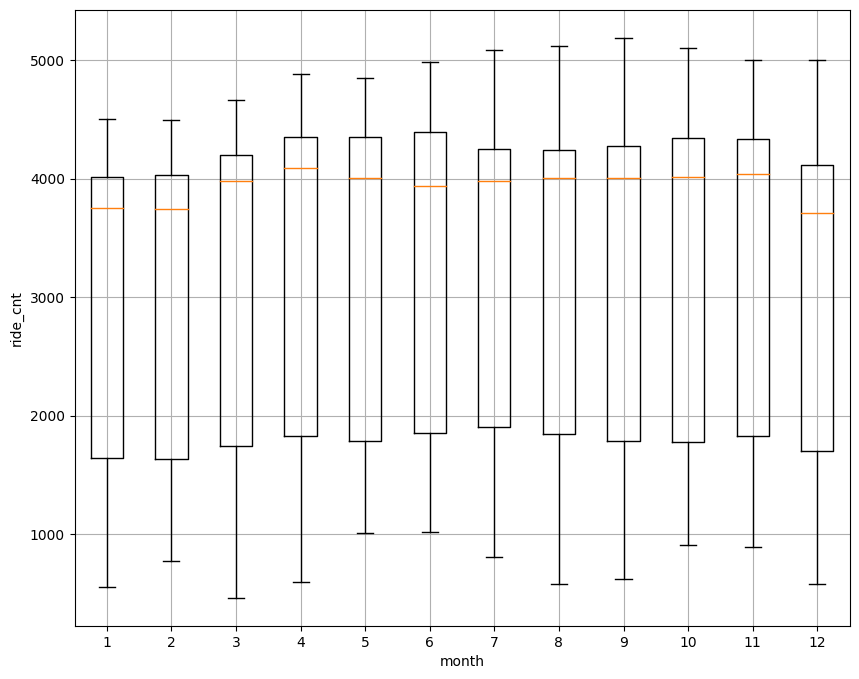

In [ ]:
plt.figure(figsize=(10, 8))
plt.boxplot([df1[df1['month'] == 1]['ride_cnt'],
             df1[df1['month'] == 2]['ride_cnt'],
             df1[df1['month'] == 3]['ride_cnt'],
             df1[df1['month'] == 4]['ride_cnt'],
             df1[df1['month'] == 5]['ride_cnt'],
             df1[df1['month'] == 6]['ride_cnt'],
             df1[df1['month'] == 7]['ride_cnt'],
             df1[df1['month'] == 8]['ride_cnt'],
             df1[df1['month'] == 9]['ride_cnt'],
             df1[df1['month'] == 10]['ride_cnt'],
             df1[df1['month'] == 11]['ride_cnt'],
             df1[df1['month'] == 12]['ride_cnt']],
            labels=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
plt.xlabel('month')
plt.ylabel('ride_cnt')
plt.grid()
plt.show()

* 대기시간

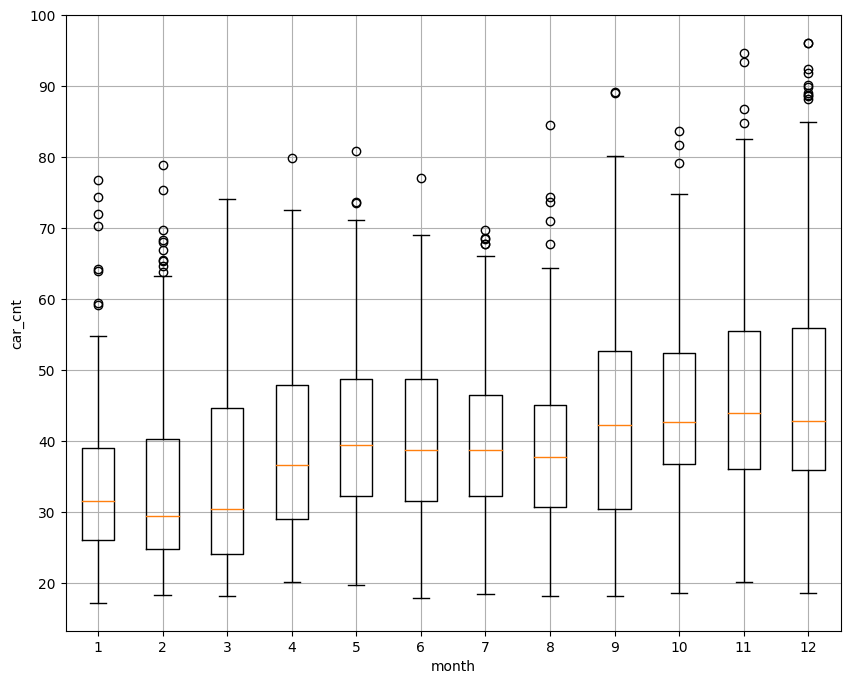

In [ ]:
plt.figure(figsize=(10, 8))
plt.boxplot([df1[df1['month'] == 1]['waiting_time'],
             df1[df1['month'] == 2]['waiting_time'],
             df1[df1['month'] == 3]['waiting_time'],
             df1[df1['month'] == 4]['waiting_time'],
             df1[df1['month'] == 5]['waiting_time'],
             df1[df1['month'] == 6]['waiting_time'],
             df1[df1['month'] == 7]['waiting_time'],
             df1[df1['month'] == 8]['waiting_time'],
             df1[df1['month'] == 9]['waiting_time'],
             df1[df1['month'] == 10]['waiting_time'],
             df1[df1['month'] == 11]['waiting_time'],
             df1[df1['month'] == 12]['waiting_time']],
            labels=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
plt.xlabel('month')
plt.ylabel('car_cnt')
plt.grid()
plt.show()

* 운임

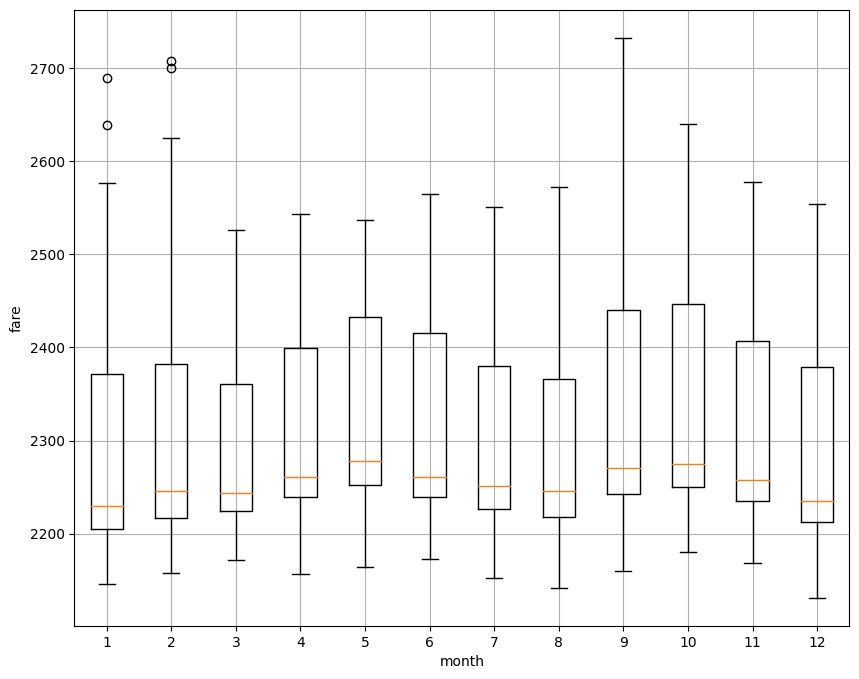

In [ ]:
plt.figure(figsize=(10, 8))
plt.boxplot([df1[df1['month'] == 1]['fare'],
             df1[df1['month'] == 2]['fare'],
             df1[df1['month'] == 3]['fare'],
             df1[df1['month'] == 4]['fare'],
             df1[df1['month'] == 5]['fare'],
             df1[df1['month'] == 6]['fare'],
             df1[df1['month'] == 7]['fare'],
             df1[df1['month'] == 8]['fare'],
             df1[df1['month'] == 9]['fare'],
             df1[df1['month'] == 10]['fare'],
             df1[df1['month'] == 11]['fare'],
             df1[df1['month'] == 12]['fare']],
            labels=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
plt.xlabel('month')
plt.ylabel('fare')
plt.grid()
plt.show()

* 이동거리

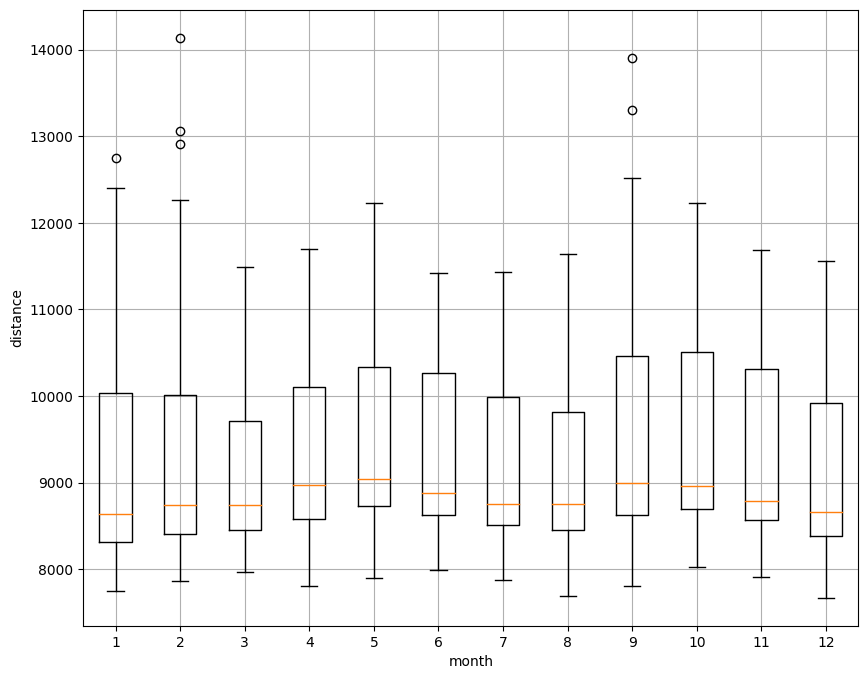

In [ ]:
plt.figure(figsize=(10, 8))
plt.boxplot([df1[df1['month'] == 1]['distance'],
             df1[df1['month'] == 2]['distance'],
             df1[df1['month'] == 3]['distance'],
             df1[df1['month'] == 4]['distance'],
             df1[df1['month'] == 5]['distance'],
             df1[df1['month'] == 6]['distance'],
             df1[df1['month'] == 7]['distance'],
             df1[df1['month'] == 8]['distance'],
             df1[df1['month'] == 9]['distance'],
             df1[df1['month'] == 10]['distance'],
             df1[df1['month'] == 11]['distance'],
             df1[df1['month'] == 12]['distance']],
            labels=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
plt.xlabel('month')
plt.ylabel('distance')
plt.grid()
plt.show()

### (6) 연도별 (boxplot 활용)

* 차량 운행수

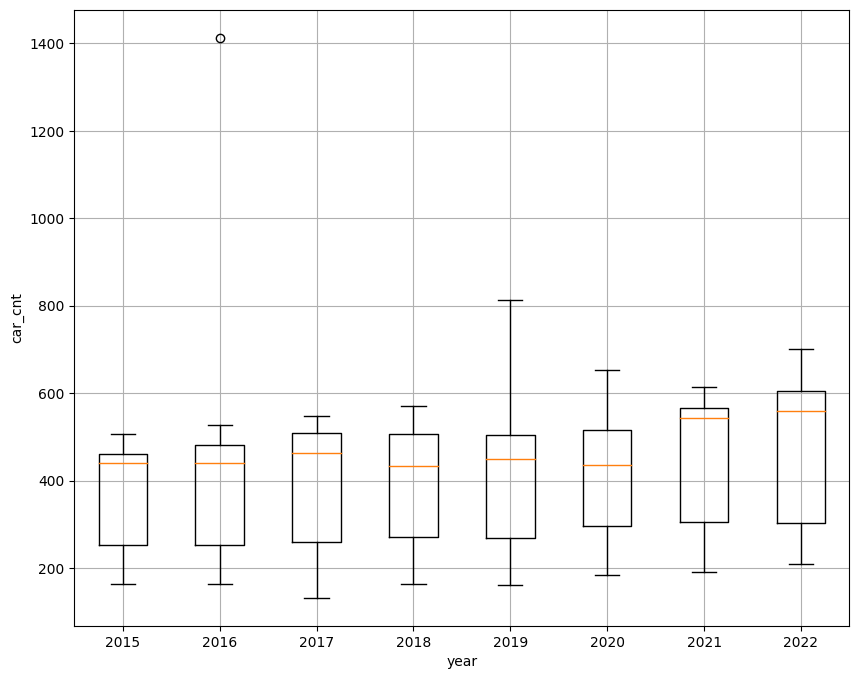

In [ ]:
plt.figure(figsize=(10, 8))
plt.boxplot([df1[df1['year'] == 2015]['car_cnt'],
             df1[df1['year'] == 2016]['car_cnt'],
             df1[df1['year'] == 2017]['car_cnt'],
             df1[df1['year'] == 2018]['car_cnt'],
             df1[df1['year'] == 2019]['car_cnt'],
             df1[df1['year'] == 2020]['car_cnt'],
             df1[df1['year'] == 2021]['car_cnt'],
             df1[df1['year'] == 2022]['car_cnt']],
            labels=['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022'])
plt.xlabel('year')
plt.ylabel('car_cnt')
plt.grid()
plt.show()

* 접수건

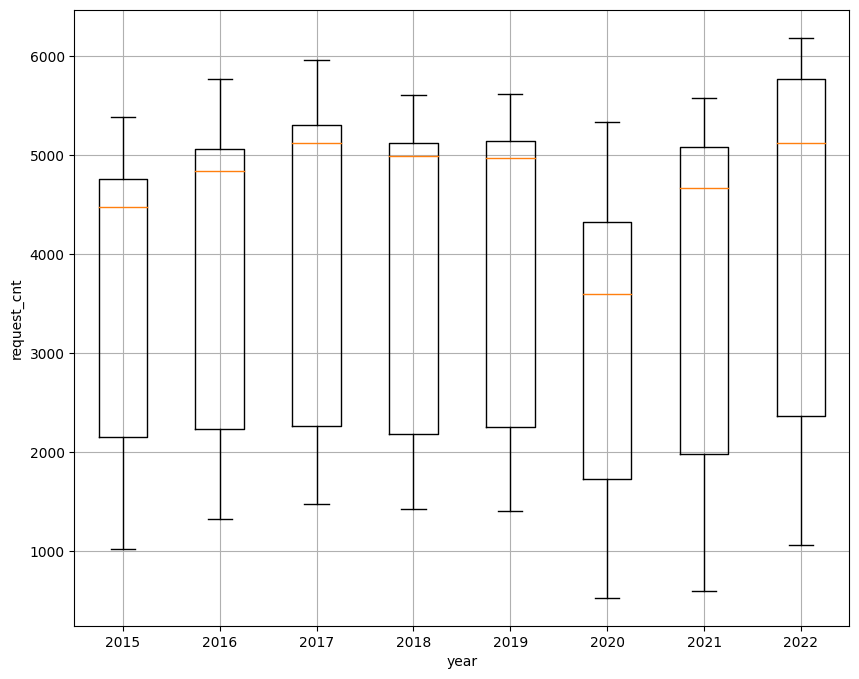

In [ ]:
plt.figure(figsize=(10, 8))
plt.boxplot([df1[df1['year'] == 2015]['request_cnt'],
             df1[df1['year'] == 2016]['request_cnt'],
             df1[df1['year'] == 2017]['request_cnt'],
             df1[df1['year'] == 2018]['request_cnt'],
             df1[df1['year'] == 2019]['request_cnt'],
             df1[df1['year'] == 2020]['request_cnt'],
             df1[df1['year'] == 2021]['request_cnt'],
             df1[df1['year'] == 2022]['request_cnt']],
            labels=['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022'])
plt.xlabel('year')
plt.ylabel('request_cnt')
plt.grid()
plt.show()

* 탑승건

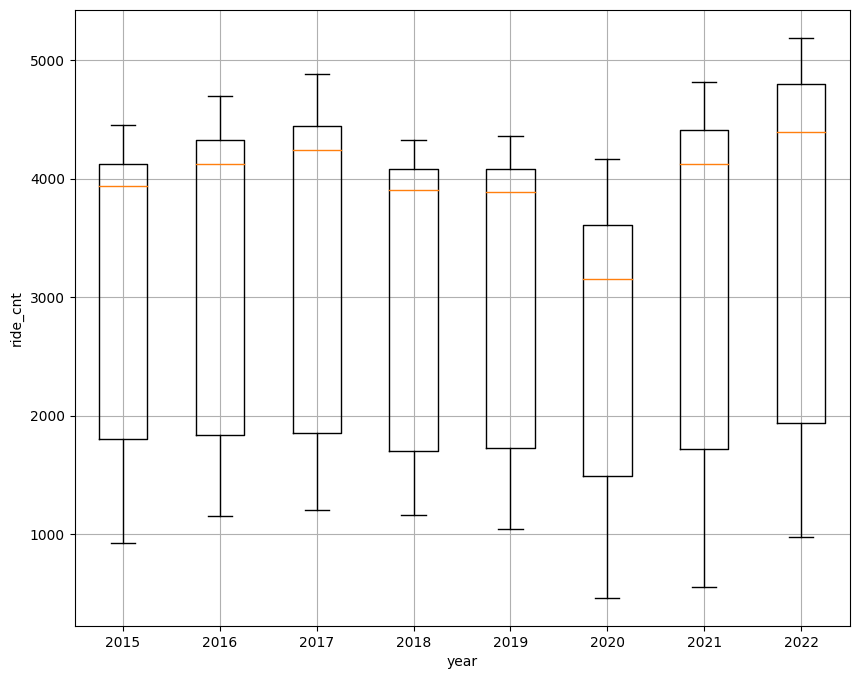

In [ ]:
plt.figure(figsize=(10, 8))
plt.boxplot([df1[df1['year'] == 2015]['ride_cnt'],
             df1[df1['year'] == 2016]['ride_cnt'],
             df1[df1['year'] == 2017]['ride_cnt'],
             df1[df1['year'] == 2018]['ride_cnt'],
             df1[df1['year'] == 2019]['ride_cnt'],
             df1[df1['year'] == 2020]['ride_cnt'],
             df1[df1['year'] == 2021]['ride_cnt'],
             df1[df1['year'] == 2022]['ride_cnt']],
            labels=['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022'])
plt.xlabel('year')
plt.ylabel('ride_cnt')
plt.grid()
plt.show()

## 3.데이터 구조 만들기

* **세부요구사항**
    * 조건 :
        * 목표 : 전날 저녁, 다음날 평균 대기시간을 예측하고자 합니다.
        * 날씨 데이터는 실제 측정값이지만, 다음 날에 대한 예보 데이터로 간주합니다.
            * 예를 들어,
                * 2020-12-23 의 날씨 데이터는 전날(12월22일) 날씨예보 데이터로 간주하여 분석을 수행합니다.
                * 2020-12-22일의 장애인 이동 데이터로 23일의 대기시간을 예측해야 하며, 이때 고려할 날씨데이터는 23일 데이터 입니다.
    * 장애인 이동 데이터를 기준으로 날씨 데이터를 붙입니다.

In [ ]:
df2['Date'] = df2['Date'] - pd.DateOffset(days=1)

In [ ]:
df2.head()

,Date,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),weekday,week,month,year
0,2011-12-31,0.4,-6.6,0.0,77.0,45.0,4.90,6,52,1,2012
1,2012-01-01,-1.2,-8.3,0.0,80.0,48.0,6.16,0,1,1,2012
2,2012-01-02,-0.4,-6.6,0.4,86.0,45.0,4.46,1,1,1,2012
3,2012-01-03,-4.6,-9.5,0.0,66.0,38.0,8.05,2,1,1,2012
4,2012-01-04,-1.4,-9.6,0.0,71.0,28.0,9.14,3,1,1,2012


In [ ]:
df1.head()

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,weekday,week,month,year
0,2015-01-01,213,1023,924,23.2,2427,10764,3,1,1,2015
1,2015-01-02,420,3158,2839,17.2,2216,8611,4,1,1,2015
2,2015-01-03,209,1648,1514,26.2,2377,10198,5,1,1,2015
3,2015-01-04,196,1646,1526,24.5,2431,10955,6,1,1,2015
4,2015-01-05,421,4250,3730,26.2,2214,8663,0,2,1,2015


### (1) target 만들기
* 예측하는 날짜, 대기시간(target)으로 기준 잡기

In [ ]:
# 익일의 대기시간(waiting time)을 오늘의 데이터를 활용하여 예측 해야하는 대상(target)으로 설정
target= data['waiting_time']

### (2) 날씨 데이터 붙이기
* merge를 활용합니다. 기준은 운행정보

In [ ]:
# 익일의 실제 날씨 데이터를 전일에 발표된 예보데이터로 판단
merge_data = pd.merge(df1, df2, on='Date', how='inner')

merge_data

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,weekday_x,week_x,month_x,...,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),weekday_y,week_y,month_y,year_y
0,2015-01-01,213,1023,924,23.2,2427,10764,3,1,1,...,-2.0,-8.9,0.0,63.0,28.0,9.07,4,1,1,2015
1,2015-01-02,420,3158,2839,17.2,2216,8611,4,1,1,...,2.4,-9.2,0.0,73.0,37.0,8.66,5,1,1,2015
2,2015-01-03,209,1648,1514,26.2,2377,10198,5,1,1,...,8.2,0.2,0.0,89.0,58.0,5.32,6,1,1,2015
3,2015-01-04,196,1646,1526,24.5,2431,10955,6,1,1,...,7.9,-0.9,0.0,95.0,52.0,6.48,0,2,1,2015
4,2015-01-05,421,4250,3730,26.2,2214,8663,0,2,1,...,4.1,-7.4,3.4,98.0,29.0,10.47,1,2,1,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2916,2022-12-26,603,5555,4605,39.2,2163,7889,0,52,12,...,3.0,-7.3,0.0,86.0,51.0,10.25,1,52,12,2022
2917,2022-12-27,669,5635,4654,44.4,2198,8178,1,52,12,...,-0.3,-5.4,0.1,92.0,40.0,10.86,2,52,12,2022
2918,2022-12-28,607,5654,4648,44.8,2161,7882,2,52,12,...,1.7,-7.8,0.0,71.0,34.0,10.88,3,52,12,2022
2919,2022-12-29,581,5250,4247,52.5,2229,8433,3,52,12,...,2.1,-4.0,0.0,87.0,38.0,10.84,4,52,12,2022


In [ ]:
merge_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2921 entries, 0 to 2920
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             2921 non-null   datetime64[ns]
 1   car_cnt          2921 non-null   int64         
 2   request_cnt      2921 non-null   int64         
 3   ride_cnt         2921 non-null   int64         
 4   waiting_time     2921 non-null   float64       
 5   fare             2921 non-null   int64         
 6   distance         2921 non-null   int64         
 7   weekday_x        2921 non-null   int64         
 8   week_x           2921 non-null   int64         
 9   month_x          2921 non-null   int64         
 10  year_x           2921 non-null   int64         
 11  temp_max         2921 non-null   float64       
 12  temp_min         2921 non-null   float64       
 13  rain(mm)         2921 non-null   float64       
 14  humidity_max(%)  2921 non-null   float64

In [ ]:
merge_data.drop(['weekday_x','week_x','month_x','year_x','weekday_y','week_y','month_y','year_y'], axis=1, inplace=True)

In [ ]:
merge_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2921 entries, 0 to 2920
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             2921 non-null   datetime64[ns]
 1   car_cnt          2921 non-null   int64         
 2   request_cnt      2921 non-null   int64         
 3   ride_cnt         2921 non-null   int64         
 4   waiting_time     2921 non-null   float64       
 5   fare             2921 non-null   int64         
 6   distance         2921 non-null   int64         
 7   temp_max         2921 non-null   float64       
 8   temp_min         2921 non-null   float64       
 9   rain(mm)         2921 non-null   float64       
 10  humidity_max(%)  2921 non-null   float64       
 11  humidity_min(%)  2921 non-null   float64       
 12  sunshine(MJ/m2)  2921 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(5)
memory usage: 319.5 KB


### (3) 새로운 feature를 생성해 봅시다.
* 날짜와 관련된 변수 추가하기 : 요일, 월, 계절, 연도
* 그외 새로운 feature 도출 : 최소 2개 이상

#### 1) 날짜와 관련된 변수 추가하기 : 요일, 월, 계절, 연도

In [ ]:
merge_data['weekday'] = merge_data['Date'].dt.day_name()

merge_data['month'] = merge_data['Date'].dt.month

season_order = ['spring', 'summer', 'autunm', 'winter']
merge_data['season'] = merge_data['Date'].dt.month.map({1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'})


merge_data['year'] = merge_data['Date'].dt.year
merge_data

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),weekday,month,season,year
0,2015-01-01,213,1023,924,23.2,2427,10764,-2.0,-8.9,0.0,63.0,28.0,9.07,Thursday,1,Winter,2015
1,2015-01-02,420,3158,2839,17.2,2216,8611,2.4,-9.2,0.0,73.0,37.0,8.66,Friday,1,Winter,2015
2,2015-01-03,209,1648,1514,26.2,2377,10198,8.2,0.2,0.0,89.0,58.0,5.32,Saturday,1,Winter,2015
3,2015-01-04,196,1646,1526,24.5,2431,10955,7.9,-0.9,0.0,95.0,52.0,6.48,Sunday,1,Winter,2015
4,2015-01-05,421,4250,3730,26.2,2214,8663,4.1,-7.4,3.4,98.0,29.0,10.47,Monday,1,Winter,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2916,2022-12-26,603,5555,4605,39.2,2163,7889,3.0,-7.3,0.0,86.0,51.0,10.25,Monday,12,Winter,2022
2917,2022-12-27,669,5635,4654,44.4,2198,8178,-0.3,-5.4,0.1,92.0,40.0,10.86,Tuesday,12,Winter,2022
2918,2022-12-28,607,5654,4648,44.8,2161,7882,1.7,-7.8,0.0,71.0,34.0,10.88,Wednesday,12,Winter,2022
2919,2022-12-29,581,5250,4247,52.5,2229,8433,2.1,-4.0,0.0,87.0,38.0,10.84,Thursday,12,Winter,2022


#### 2) 공휴일 정보
* workalendar 패키지를 설치, 대한민국 공휴일 정보

In [ ]:
!pip install workalendar

In [ ]:
from workalendar.asia import SouthKorea
cal = SouthKorea()
pd.DataFrame(cal.holidays(2023))

,0,1
0,2023-01-01,New year
1,2023-01-21,Korean New Year's Day
2,2023-01-22,Korean New Year's Day
3,2023-01-23,Korean New Year's Day
4,2023-03-01,Independence Day
5,2023-05-05,Children's Day
6,2023-05-26,Buddha's Birthday
7,2023-06-06,Memorial Day
8,2023-08-15,Liberation Day
9,2023-09-28,Midautumn Festival


* 휴무일 데이터셋 만들기 2015 ~ 2022
* 실제로 휴무일에 해당하지만 workalendar 라이브러리에 없는 날짜는 직접 추가해봅시다.
    * 휴무일 장애인 콜택시의 접수건 변화에 대한 특징을 찾아 이를 바탕으로 데이터를 조회하여 찾아볼 수 있음

In [ ]:
years = [i for i in range(2015, 2023)]

holiday = []
for i in years:
        for j in cal.holidays(i):
            holiday.append(j[0])

* 기존 데이터에 휴무일 정보 결합하기.
* 휴무일이 아닌 날짜는 0으로 저장

In [ ]:
merge_data['holiday']=np.where(merge_data['Date'].isin(holiday),1,0)
merge_data

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),weekday,month,season,year,holiday
0,2015-01-01,213,1023,924,23.2,2427,10764,-2.0,-8.9,0.0,63.0,28.0,9.07,Thursday,1,Winter,2015,1
1,2015-01-02,420,3158,2839,17.2,2216,8611,2.4,-9.2,0.0,73.0,37.0,8.66,Friday,1,Winter,2015,0
2,2015-01-03,209,1648,1514,26.2,2377,10198,8.2,0.2,0.0,89.0,58.0,5.32,Saturday,1,Winter,2015,0
3,2015-01-04,196,1646,1526,24.5,2431,10955,7.9,-0.9,0.0,95.0,52.0,6.48,Sunday,1,Winter,2015,0
4,2015-01-05,421,4250,3730,26.2,2214,8663,4.1,-7.4,3.4,98.0,29.0,10.47,Monday,1,Winter,2015,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2916,2022-12-26,603,5555,4605,39.2,2163,7889,3.0,-7.3,0.0,86.0,51.0,10.25,Monday,12,Winter,2022,0
2917,2022-12-27,669,5635,4654,44.4,2198,8178,-0.3,-5.4,0.1,92.0,40.0,10.86,Tuesday,12,Winter,2022,0
2918,2022-12-28,607,5654,4648,44.8,2161,7882,1.7,-7.8,0.0,71.0,34.0,10.88,Wednesday,12,Winter,2022,0
2919,2022-12-29,581,5250,4247,52.5,2229,8433,2.1,-4.0,0.0,87.0,38.0,10.84,Thursday,12,Winter,2022,0


#### 3) 7일 이동평균 대기시간
* rolling().mean() 사용

In [ ]:
merge_data['avg7day'] = merge_data['waiting_time'].rolling(window=7).mean()
merge_data

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),weekday,month,season,year,holiday,avg7day
0,2015-01-01,213,1023,924,23.2,2427,10764,-2.0,-8.9,0.0,63.0,28.0,9.07,Thursday,1,Winter,2015,1,NaN
1,2015-01-02,420,3158,2839,17.2,2216,8611,2.4,-9.2,0.0,73.0,37.0,8.66,Friday,1,Winter,2015,0,NaN
2,2015-01-03,209,1648,1514,26.2,2377,10198,8.2,0.2,0.0,89.0,58.0,5.32,Saturday,1,Winter,2015,0,NaN
3,2015-01-04,196,1646,1526,24.5,2431,10955,7.9,-0.9,0.0,95.0,52.0,6.48,Sunday,1,Winter,2015,0,NaN
4,2015-01-05,421,4250,3730,26.2,2214,8663,4.1,-7.4,3.4,98.0,29.0,10.47,Monday,1,Winter,2015,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2916,2022-12-26,603,5555,4605,39.2,2163,7889,3.0,-7.3,0.0,86.0,51.0,10.25,Monday,12,Winter,2022,0,43.485714
2917,2022-12-27,669,5635,4654,44.4,2198,8178,-0.3,-5.4,0.1,92.0,40.0,10.86,Tuesday,12,Winter,2022,0,42.771429
2918,2022-12-28,607,5654,4648,44.8,2161,7882,1.7,-7.8,0.0,71.0,34.0,10.88,Wednesday,12,Winter,2022,0,43.514286
2919,2022-12-29,581,5250,4247,52.5,2229,8433,2.1,-4.0,0.0,87.0,38.0,10.84,Thursday,12,Winter,2022,0,42.957143


#### 4) 탑승률

In [ ]:
merge_data['ride_rate'] = (merge_data['ride_cnt'] / merge_data['request_cnt']) * 100

print(merge_data.head())

        Date  car_cnt  request_cnt  ride_cnt  waiting_time  fare  distance  \
0 2015-01-01      213         1023       924          23.2  2427     10764   
1 2015-01-02      420         3158      2839          17.2  2216      8611   
2 2015-01-03      209         1648      1514          26.2  2377     10198   
3 2015-01-04      196         1646      1526          24.5  2431     10955   
4 2015-01-05      421         4250      3730          26.2  2214      8663   

   temp_max  temp_min  rain(mm)  humidity_max(%)  humidity_min(%)  \
0      -2.0      -8.9       0.0             63.0             28.0   
1       2.4      -9.2       0.0             73.0             37.0   
2       8.2       0.2       0.0             89.0             58.0   
3       7.9      -0.9       0.0             95.0             52.0   
4       4.1      -7.4       3.4             98.0             29.0   

   sunshine(MJ/m2)   weekday  month  season  year  holiday  avg7day  ride_rate  
0             9.07  Thursday      1

In [ ]:
import joblib

joblib.dump(merge_data, '/content/drive/MyDrive/미니프로젝트/2차_미세먼지 농도 예측, 장애인 콜택시 대기시간 예측 머신러닝 모델/2023.09.12_미니프로젝트2차_2일차 장애인 콜택시 대기시간 예측/data1.pkl')

['/content/drive/MyDrive/미니프로젝트/2차_미세먼지 농도 예측, 장애인 콜택시 대기시간 예측 머신러닝 모델/2023.09.12_미니프로젝트2차_2일차 장애인 콜택시 대기시간 예측/data1.pkl']